In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix
import itertools
from glob import glob
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-05-10 11:38:11.374210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 11:38:11.374326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 11:38:11.511311: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [2]:
train = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_train.csv")
test = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_test.csv")

In [3]:
train.head(10)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print("train.shape: ",train.shape)
print("test.shape: ",test.shape)

train.shape:  (60000, 785)
test.shape:  (10000, 785)


In [5]:
x_train = train.drop(labels = ["label"],axis=1)
y_train = train["label"]
x_test = test.drop(labels = ["label"],axis=1)
y_test = test["label"]

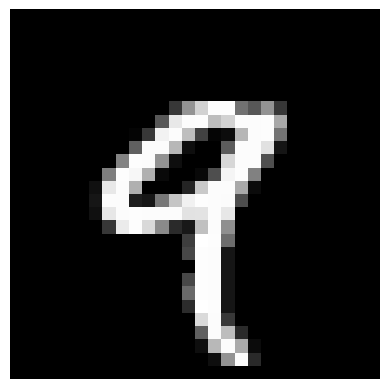

In [6]:
img = x_train.iloc[4].values.reshape(28,28)
plt.imshow(img, cmap ="gray")
plt.axis("off")
plt.show()

In [7]:
y_train.value_counts()

label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

## Normalization

In [8]:
x_train = x_train / 255.0
x_test = x_test / 255.0
print("x_train.shape",x_train.shape)
print("x_test.shape",x_test.shape)


x_train.shape (60000, 784)
x_test.shape (10000, 784)


## Reshape

In [9]:
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)
print("x_train.shape",x_train.shape)
print("x_test.shape",x_test.shape)

x_train.shape (60000, 28, 28, 1)
x_test.shape (10000, 28, 28, 1)


## Label Encoding

In [10]:
from keras.utils import to_categorical # convert to one-hot-encoding
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

## TrainTestSplit

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=2)
print("x_train shape",x_train.shape)
print("x_test shape",x_val.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_val.shape)

x_train shape (48000, 28, 28, 1)
x_test shape (12000, 28, 28, 1)
y_train shape (48000, 10)
y_test shape (12000, 10)


# CNN Model

In [12]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),padding="Same",activation="relu",input_shape=(28,28,1)))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size=(4,4),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(3,3),strides=(3,3)))

model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10,activation="softmax"))

epochs = 50
batch_size= 32

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [13]:
model.compile(optimizer="rmsprop", loss = "categorical_crossentropy",metrics=["accuracy"])

In [14]:
datagen = ImageDataGenerator( 
        shear_range = 0.2,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip = True)

datagen.fit(x_train)

In [15]:
history=model.fit(datagen.flow(x_train,y_train,batch_size=batch_size),
                            epochs=epochs,validation_data=(x_val,y_val),
                            steps_per_epoch=3200//batch_size)

Epoch 1/50
  1/100 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.1250 - loss: 2.3218

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.1526 - loss: 2.2510 - val_accuracy: 0.3779 - val_loss: 1.7429
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.3331 - loss: 1.7843 - val_accuracy: 0.5865 - val_loss: 1.2157
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.4750 - loss: 1.4463 - val_accuracy: 0.6338 - val_loss: 1.0204
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5527 - loss: 1.2417 - val_accuracy: 0.7016 - val_loss: 0.8617
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.5862 - loss: 1.1139 - val_accuracy: 0.7599 - val_loss: 0.7213
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6340 - loss: 0.9887 - val_accuracy: 0.7342 - val_loss: 0.7108
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6552 - loss: 0.9758 - val_accuracy: 0.8034 - val_loss: 0.5826
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6903 - loss: 0.8685 - val_accuracy: 0.751

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8483 - val_loss: 0.4208
Epoch 17/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.7913 - loss: 0.6111 - val_accuracy: 0.8830 - val_loss: 0.3614
Epoch 18/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8211 - loss: 0.5596 - val_accuracy: 0.8907 - val_loss: 0.3479
Epoch 19/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8062 - loss: 0.5960 - val_accuracy: 0.9059 - val_loss: 0.3090
Epoch 20/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8302 - loss: 0.5373 - val_accuracy: 0.8738 - val_loss: 0.3938
Epoch 21/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8270 - loss: 0.5169 - val_accuracy: 0.8965 - val_loss: 0.3149
Epoch 22/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8239 - loss: 0.5393 - val_accuracy: 0.8963 - val_loss: 0.3191
Epoch 23/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.8537 - loss: 0.4405 - val_

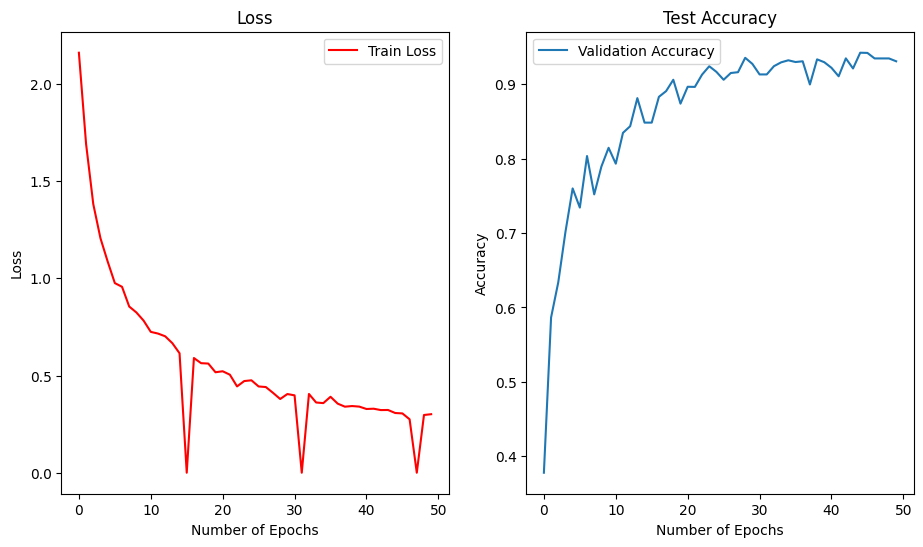

In [16]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label = "Train Loss",color="r")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Test Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [17]:
scores = model.evaluate(x_val, y_val, verbose=0)
print("{}: {:.2f}%".format("Accuracy", scores[1]*100))

Accuracy: 93.08%


375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


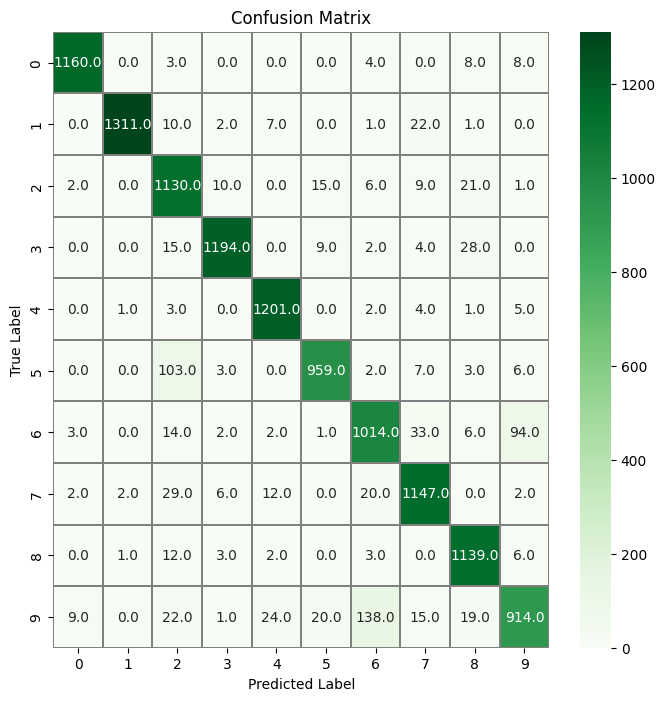

In [18]:
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(x_val)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

* ##  This is the conclusion of my work. 
* ##  We should update epoch, change hyperparameter tuning and add layer for to get better accuracy rate.